In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generate 2D Gaussian mixture data

In [2]:
# dimension
d = 2
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=3)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(3))

data = []
labels = []
means = np.array([
    [2.0, 2.0],
    [-2.0, 2.0],
    [-0.0, -2.0],
])

cov = 1.0 * np.eye(d)
# random covariances
for k in range(3):
    # this is indeed a covariance matrix
    data.append([np.random.multivariate_normal(means[k], cov, N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [3]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 20,
    'hidden_size_decoder': 20,
    'emb_size': 2,
}

use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [4]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
# torch.save(model_no_penalty.state_dict(), 'gauss_2d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(config_layers, 
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
# torch.save(model_penalty.state_dict(), 'gauss_2d_{}_epochs_penalty.pt'.format(n_epochs))

model_strong_penalty = Model(config_layers, 
                             eta=eta,
                             tol=tol,
                             lr=lr,
                             batch_size=batch_size,
                             use_cuda=use_cuda,
                             connectivity_penalty=1000.0,
                            )

model_strong_penalty.train(data, n_epochs)
# torch.save(model_strong_penalty.state_dict(), 'gauss_2d_{}_epochs_strong_penalty.pt'.format(n_epochs))

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 280it/s, connectivity loss=0, reconstruction loss=3.79]
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 377it/s, connectivity loss=0, reconstruction loss=3.13]
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 250it/s, connectivity loss=0, reconstruction loss=2.64]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 260it/s, connectivity loss=0, reconstruction loss=2.13]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 295it/s, connectivity loss=0, reconstruction loss=1.31]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 309it/s, connectivity loss=0, reconstruction loss=0.472]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 273it/s, connectivity loss=0, reconstruction loss=0.159]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 230it/s, connectivity loss=0, reconstruction loss=0.103] 
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 229it/s, connectivity loss=0, reconstruction loss=0.0722] 
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 271it/s, connectivity loss=0

### Results

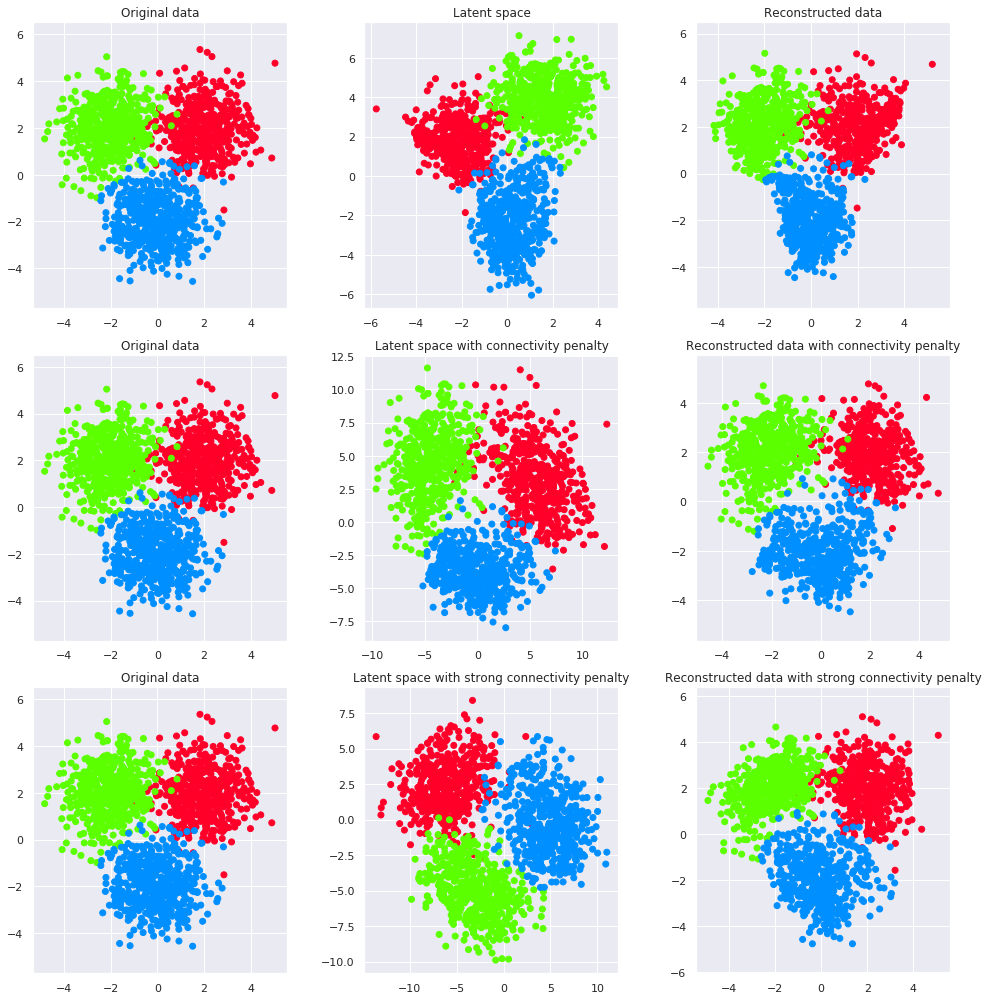

[0.003741944, 0.12517201001839767, 1.5544055]
[0.0026244551, 0.12859914014942253, 1.3518901]
[0.009080481, 0.2711255338845689, 3.183018]
[0.008445887, 0.2686041182402852, 2.8202248]


In [5]:
fig, axes = plt.subplots(figsize=(14, 14), nrows=3, ncols=3)

ax = axes[0, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')


ax = axes[1, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[1, 1]
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')

ax = axes[1, 2]
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty')

ax = axes[2, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[2, 1]
latent_space_strong_penalty = model_strong_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_strong_penalty[:, 0], latent_space_strong_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with strong connectivity penalty')

ax = axes[2, 2]
reconstructed_data = model_strong_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with strong connectivity penalty')

plt.tight_layout()
plt.show()

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))
print(barcode_stats(latent_space_strong_penalty))